In [33]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot
from pandas.api import types
from catboost import CatBoostRegressor
from sklearn.metrics import *

In [34]:
data = pd.read_excel('pollution_data.xlsx')
data.drop(columns=['No'], axis=0, inplace=True)
data = data[24:]
print(data.head())
print(data.shape)

    year  month  day  hour  pollution  DEWP  TEMP    PRES cbwd   Iws  Is  Ir
24  2010      1    2     0      129.0   -16  -4.0  1020.0   SE  1.79   0   0
25  2010      1    2     1      148.0   -15  -4.0  1020.0   SE  2.68   0   0
26  2010      1    2     2      159.0   -11  -5.0  1021.0   SE  3.57   0   0
27  2010      1    2     3      181.0    -7  -5.0  1022.0   SE  5.36   1   0
28  2010      1    2     4      138.0    -7  -5.0  1022.0   SE  6.25   2   0
(43800, 12)


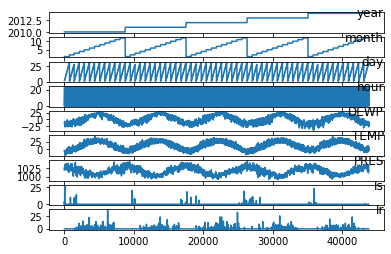

In [35]:
"""
Plotting Data
"""

values = data.values

groups = [0, 1, 2, 3, 5, 6, 7, 10, 11]
i = 1

pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(data.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

<AxesSubplot:>

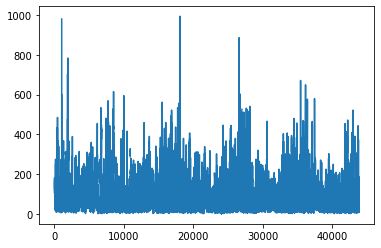

In [36]:
data['pollution'].plot()

In [37]:
data.describe()

,year,month,day,hour,pollution,DEWP,TEMP,PRES,Iws,Is,Ir
count,43800.000000,43800.000000,43800.000000,43800.000000,41757.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,2012.001096,6.526575,15.735890,11.500000,98.613215,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,1.413454,3.447092,8.795077,6.922266,92.050387,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [38]:
data.isna().sum()

year            0
month           0
day             0
hour            0
pollution    2043
DEWP            0
TEMP            0
PRES            0
cbwd            0
Iws             0
Is              0
Ir              0
dtype: int64

In [39]:
"""
Removing Cumulative Sum
"""

data['Is_shift'] = data.groupby(['year', 'month', 'day'])['Is'].shift(1)
data['Is_shift'] = data['Is_shift'].combine_first(data['Is'])
data['Is'] = data['Is'] - data['Is_shift']

data['Ir_shift'] = data.groupby(['year', 'month', 'day'])['Ir'].shift(1)
data['Ir_shift'] = data['Ir_shift'].combine_first(data['Ir'])
data['Ir'] = data['Ir'] - data['Ir_shift']

data

,year,month,day,hour,pollution,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,Is_shift,Ir_shift
24,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0.0,0.0,0.0,0.0
25,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0.0,0.0,0.0,0.0
26,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0.0,0.0,0.0,0.0
27,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1.0,0.0,0.0,0.0
28,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0.0,0.0,0.0,0.0
43820,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0.0,0.0,0.0,0.0
43821,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0.0,0.0,0.0,0.0
43822,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0.0,0.0,0.0,0.0


In [40]:
"""
Imputing Data
"""

data['pollution'].fillna(data['pollution'].mean(), inplace=True)
data.isna().sum()

year         0
month        0
day          0
hour         0
pollution    0
DEWP         0
TEMP         0
PRES         0
cbwd         0
Iws          0
Is           0
Ir           0
Is_shift     0
Ir_shift     0
dtype: int64

In [47]:
"""
Defining Response and Target Variable
"""

include_pollution = True
if include_pollution:
    covariates = data.columns
else:
    covariates = [column for column in data.columns if column not in ['pollution']]
print(covariates)

response = 'pollution_next_hour'

data[response] = data['pollution'].shift(-1)
data.dropna(inplace=True)
data.head()



Index(['year', 'month', 'day', 'hour', 'pollution', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir', 'Is_shift', 'Ir_shift',
       'pollution_next_hour'],
      dtype='object')


,year,month,day,hour,pollution,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,Is_shift,Ir_shift,pollution_next_hour
24,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0.0,0.0,0.0,0.0,148.0
25,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0.0,0.0,0.0,0.0,159.0
26,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0.0,0.0,0.0,0.0,181.0
27,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1.0,0.0,0.0,0.0,138.0
28,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,1.0,0.0,1.0,0.0,109.0


In [48]:
"""
Dividing Data Into Train and Validation
"""

records = data.shape[0]
train_index = int(records*0.6)
val_index = train_index + int(records*0.2)
print(f'Train Data Index: {train_index}...Validation Data Index: {val_index}')

data['cbwd'] = data['cbwd'].astype('category')

train_data = data[:train_index].reset_index()
val_data = data[train_index+1: val_index].reset_index()
test_data = data[val_index+1:].reset_index()
print(f'Train Data Shape {train_data.shape}...Validation Data Shape {val_data.shape}...Test Data Shape {test_data.shape}')

Train Data Index: 26278...Validation Data Index: 35037
Train Data Shape (26278, 16)...Validation Data Shape (8758, 16)...Test Data Shape (8760, 16)


In [49]:
"""
Categorical Columns
"""

x_train = train_data[covariates]
y_train = train_data[response]
x_val = val_data[covariates]
y_val = val_data[response]
x_test = test_data[covariates]
y_test = test_data[response]
print(f'x_train shape {x_train.shape}...x_val shape {x_val.shape}...x_test shape {x_test.shape}')

is_cat = x_train.apply(types.is_categorical_dtype)
categorical_features_indices = np.where(is_cat)[0]
print(categorical_features_indices)

x_train shape (26278, 15)...x_val shape (8758, 15)...x_test shape (8760, 15)
[8]


In [50]:
"""
Model Training
"""

model_params = dict(
  iterations=1000, 
  depth=10, 
  learning_rate=0.06, 
  loss_function='RMSE',
  random_seed=42,
  use_best_model=True,
  cat_features=categorical_features_indices)

model = CatBoostRegressor(**model_params)

model.fit(x_train, 
          y_train,
          eval_set=(x_val, y_val),
          verbose=False)

with open('catboost_model.pkl', 'wb') as file:
  pickle.dump(model, file)

In [51]:
"""
Model Prediction
"""

train_pred = model.predict(x_train)
mape = mean_squared_error(y_train, train_pred, squared=False)
print(f'RMSE on Training Data: {mape}')

val_pred = model.predict(x_val)
mape = mean_squared_error(y_val, val_pred, squared=False)
print(f'RMSE on Validation Data: {mape}')

test_pred = model.predict(x_test)
mape = mean_squared_error(y_test, test_pred, squared=False)
print(f'RMSE on Test Data: {mape}')

RMSE on Training Data: 0.7416784911581512
RMSE on Validation Data: 11.395657110733179
RMSE on Test Data: 4.621562952632038


In [52]:

val_data['predicted'] = val_pred
val_data


,index,year,month,day,hour,pollution,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,Is_shift,Ir_shift,pollution_next_hour,predicted
0,26303,2012,12,31,23,39.0,-10,-6.0,1018.0,NW,1.79,0.0,0.0,0.0,0.0,35.0,34.587146
1,26304,2013,1,1,0,35.0,-10,-5.0,1018.0,NW,5.81,0.0,0.0,0.0,0.0,31.0,31.157979
2,26305,2013,1,1,1,31.0,-11,-7.0,1017.0,NW,9.83,0.0,0.0,0.0,0.0,32.0,31.851813
3,26306,2013,1,1,2,32.0,-11,-7.0,1017.0,NW,11.62,0.0,0.0,0.0,0.0,21.0,21.460272
4,26307,2013,1,1,3,21.0,-14,-10.0,1018.0,NW,14.75,0.0,0.0,0.0,0.0,16.0,15.784858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8753,35056,2013,12,31,16,16.0,-18,9.0,1012.0,NW,92.97,0.0,0.0,0.0,0.0,21.0,20.707429
8754,35057,2013,12,31,17,21.0,-19,8.0,1012.0,NW,102.80,0.0,0.0,0.0,0.0,15.0,15.707164
8755,35058,2013,12,31,18,15.0,-19,8.0,1013.0,NW,109.95,0.0,0.0,0.0,0.0,22.0,21.796193
8756,35059,2013,12,31,19,22.0,-19,7.0,1013.0,NW,114.87,0.0,0.0,0.0,0.0,18.0,18.204993
